In [4]:
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px

from sklearn.feature_extraction.text import TfidfVectorizer

import umap
import hdbscan

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# План
1. Из-за ограничений в мощностях было принято решение взять семпл в несколько десятков тысяч событий и проводить кластеризацию на них
2. В качестве метода кластеризации используем HDBSCAN, т.к. он показывает себя лучшим на различных бектестах
3. В качестве метода снижения размерности будем использовать UMAP
4. Кластеризацию будем проводить исключительно на эмбеддингах описания приложения
5. Визуализацию будем проводить в Tensorflow Projector для удобного отображения

# 1. Подготовим файл с эмбеддингами

In [5]:
google_features = pd.read_csv('../data/parsed_final.csv', usecols=['appId', 'description'])

google_features.rename(columns={'appId': 'bundle'}, inplace=True)

print(google_features.shape)
google_features.head()

(59369, 2)


,bundle,description
0,com.MadOut.BIG,Number one mobile game with open world! Online...
1,com.easybrain.solitaire.klondike.free,Solitaire is a time-tested classic card game e...
2,com.orbitalknight.ridiculousfreekick,"Get to the goal!Overtake your opponents, move ..."
3,com.FidgetTrading3D.game,Want to collect ALL The Fidgets In The World? ...
4,com.hwg.sos,"How often do you talk to your brain? Hey, frie..."


In [6]:
vectorizer = TfidfVectorizer(max_features=128)

description_embeddings = vectorizer.fit_transform(google_features['description'].fillna('nan').unique().tolist())

description_embeddings_df = pd.DataFrame(description_embeddings.toarray(), columns=['tfidf_' + f for f in vectorizer.get_feature_names()])

In [7]:
google_features = google_features.join(description_embeddings_df)

google_features.drop(columns=['description'], inplace=True)

# Загрузим train

In [ ]:
train = pd.read_csv('../data/main.csv', usecols=['bundle', 'os'])

train = train[train['os'] == 'android'].reset_index(drop=True)

train = train.sample(50_000, random_state=42)

train.drop(columns=['os'], inplace=True)

print(train.shape)
train.head()

(50000, 1)


,bundle
25206952,com.smallgiantgames.empires
2347384,com.mars.avgchapters
20238933,com.fugo.wow
29495207,com.ftkg.wordtower
30066808,com.belkatechnologies.clockmaker


In [39]:
train.to_csv('../data/train_sample.csv', index=False)

In [8]:
#train = pd.read_csv('../data/train_sample.csv')

In [9]:
train = train.merge(google_features, on='bundle', how='left')

print(train.shape)
train.head()

(50000, 129)


,bundle,tfidf_2021,tfidf_3d,tfidf_adventure,tfidf_all,tfidf_also,tfidf_amazing,tfidf_an,tfidf_and,tfidf_android,tfidf_any,tfidf_app,tfidf_application,tfidf_are,tfidf_as,tfidf_at,tfidf_battle,tfidf_be,tfidf_beautiful,tfidf_become,tfidf_best,tfidf_but,tfidf_by,tfidf_can,tfidf_car,tfidf_choose,tfidf_city,tfidf_com,tfidf_create,tfidf_different,tfidf_do,tfidf_download,tfidf_drive,tfidf_driving,tfidf_each,tfidf_easy,tfidf_enjoy,tfidf_experience,tfidf_features,tfidf_find,tfidf_for,tfidf_free,tfidf_friends,tfidf_from,tfidf_fun,tfidf_game,tfidf_games,tfidf_get,tfidf_has,tfidf_have,tfidf_help,tfidf_high,tfidf_how,tfidf_if,tfidf_in,tfidf_into,tfidf_is,tfidf_it,tfidf_just,tfidf_level,tfidf_levels,tfidf_like,tfidf_love,tfidf_make,tfidf_many,tfidf_mode,tfidf_more,tfidf_most,tfidf_music,tfidf_need,tfidf_new,tfidf_no,tfidf_not,tfidf_now,tfidf_of,tfidf_offline,tfidf_on,tfidf_one,tfidf_only,tfidf_or,tfidf_other,tfidf_our,tfidf_out,tfidf_own,tfidf_phone,tfidf_photo,tfidf_play,tfidf_police,tfidf_puzzle,tfidf_racing,tfidf_real,tfidf_realistic,tfidf_robot,tfidf_screen,tfidf_shooting,tfidf_simple,tfidf_simulator,tfidf_skills,tfidf_so,tfidf_start,tfidf_take,tfidf_that,tfidf_the,tfidf_their,tfidf_them,tfidf_there,tfidf_this,tfidf_time,tfidf_to,tfidf_truck,tfidf_try,tfidf_unique,tfidf_up,tfidf_us,tfidf_use,tfidf_very,tfidf_video,tfidf_wallpaper,tfidf_wallpapers,tfidf_want,tfidf_way,tfidf_we,tfidf_when,tfidf_which,tfidf_will,tfidf_with,tfidf_world,tfidf_you,tfidf_your
0,com.smallgiantgames.empires,0.000000,0.0,0.248586,0.062548,0.000000,0.107223,0.151575,0.478254,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.135104,0.000000,0.000000,0.106604,0.0,0.000000,0.071901,0.058123,0.0,0.000000,0.000000,0.000000,0.000000,0.089261,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.102243,0.071194,0.000000,0.000000,0.000000,0.062359,0.172516,0.000000,0.000000,0.000000,0.099080,0.0,0.000000,0.000000,0.197566,0.0,0.100122,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.076054,0.000000,0.0000,0.089953,0.235721,0.000000,0.120188,0.000000,0.000000,0.000000,0.089525,0.000000,0.00000,0.000000,0.0,0.0,0.071610,0.0,0.136264,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.108211,0.209173,0.070494,0.043927,0.0,0.000000,0.000000,0.000000,0.000000,0.132802,0.0,0.000000,0.109882,0.187771,0.100782,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.249535,0.091626,0.046220,0.437073
1,com.mars.avgchapters,0.000000,0.0,0.044499,0.067180,0.000000,0.000000,0.081400,0.249053,0.0,0.000000,0.000000,0.0,0.043891,0.075361,0.000000,0.000000,0.024394,0.000000,0.038166,0.0,0.000000,0.077226,0.062427,0.0,0.343671,0.045405,0.111377,0.041311,0.031957,0.000000,0.033001,0.04954,0.0,0.039261,0.0,0.000000,0.0,0.024660,0.000000,0.018302,0.000000,0.000000,0.172025,0.095412,0.066977,0.061764,0.082369,0.000000,0.074368,0.000000,0.0,0.000000,0.000000,0.159147,0.0,0.107537,0.0,0.034962,0.000000,0.000000,0.0,0.125834,0.119783,0.000000,0.0,0.026364,0.0,0.0,0.00000,0.081686,0.000000,0.0000,0.032205,0.202542,0.000000,0.064544,0.029977,0.038097,0.068831,0.000000,0.134326,0.00000,0.118739,0.0,0.0,0.051275,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.03184,0.077483,0.037444,0.151428,0.393162,0.0,0.000000,0.000000,0.040777,0.000000,0.348667,0.0,0.038967,0.078680,0.000000,0.036082,0.000000,0.0,0.0,0.0,0.0,0.000000,0.037283,0.0,0.037824,0.0,0.067791,0.142941,0.000000,0.248216,0.365120
2,com.fugo.wow,0.000000,0.0,0.035485,0.053572,0.079195,0.030612,0.021637,0.248253,0.0,0.025198,0.000000,0.0,0.052500,0.060095,0.100214,0.000000,0.097262,0.032363,0.030435,0.0,0.054934,0.082109,0.016594,0.0,0.000000,0.036207,0.000000,0.065886,0.050967,0.027191,0.000000,0.00000,0.0,0.093924,0.0,0.049637,0.0,0.000000,0.111115,0.000000,0.000000,0.057722,0.058790,0.050723,0.160228,0.000000,0.065683,0.027364,0.079071,0.000000,0.0,0.085335,0.046013,0.056404,0.0,0.100045,0.0,0.000000,0.064807,0.091602,0.0,0.000000,0.02388

In [10]:
# заполним пропуски
train.fillna(0, inplace=True)

# Проведем кластеризацию

In [13]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=64, 
                            metric='cosine').fit_transform(train.drop(columns=['bundle']))

In [14]:
umap_embeddings = pd.DataFrame(umap_embeddings)

In [17]:
cluster = hdbscan.HDBSCAN(min_cluster_size=50, metric='euclidean').fit(umap_embeddings.fillna(0)) # cluster_selection_method='eom'

In [18]:
print('Уникальных кластеров:', len(set(cluster.labels_)))

Уникальных кластеров: 24


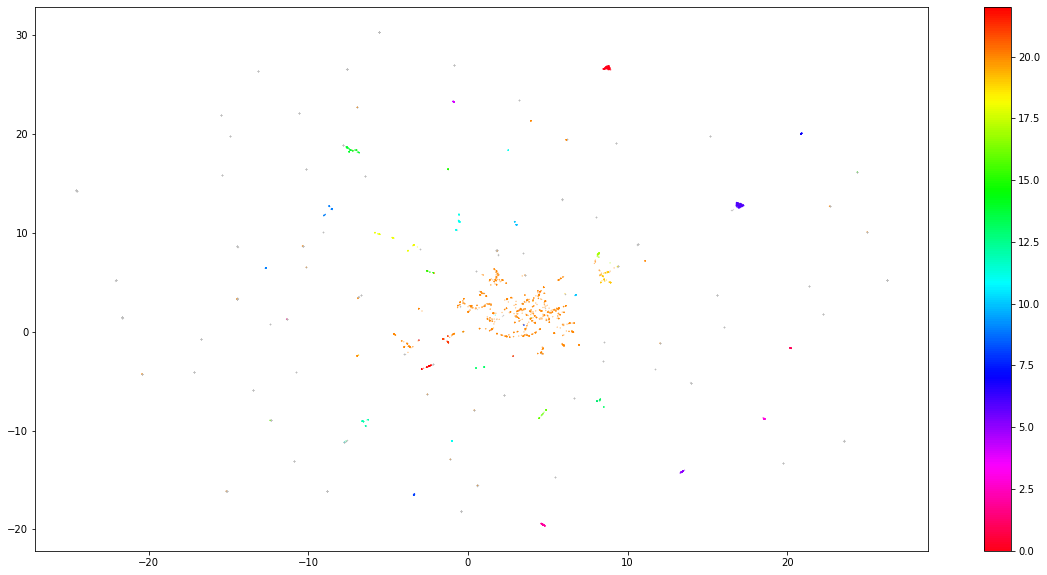

In [19]:
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(train.drop(columns=['bundle']))
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()
plt.show()

# Выгрузим файл для 3D визуализации

In [58]:
# Tensorflow Projector поддерживает максимум 10 тысяч точек, поэтому выгрузим именно столько
train.drop(columns=['bundle']).sample(10_000, random_state=42).to_csv('./data/sample_tf_pr.tsv', index=False, sep='\t', header=None)

In [71]:
train[['bundle']].sample(10_000, random_state=42).to_csv('./data/sample_tf_pr_labels.tsv', index=False, sep='\t', header=None)